Import Libraries

In [1]:
from prophet import Prophet
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
import imblearn
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_regression
from statsmodels.tsa.stattools import adfuller

C:\Users\abarr\.conda\envs\Tensorflow\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read in dataset

In [2]:
df=pd.read_csv(r"C:\Users\abarr\Downloads\Time_series_analysis_and_forecast_DATASET.csv")
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,01/09/2010 00:00,15.8,1688.215,3.69,23.710
1,01/09/2010 01:00,15.8,1669.195,3.69,22.635
2,01/09/2010 02:00,15.8,1491.980,3.69,22.565
3,01/09/2010 03:00,15.8,1330.760,3.69,18.910
4,01/09/2010 04:00,15.8,1247.940,3.69,18.030


Convert FullDate to datetime index

In [3]:
df['FullDate']=pd.to_datetime(df['FullDate'])

In [4]:
df.dtypes

FullDate     datetime64[ns]
Tmax                float64
SysLoad             float64
GasPrice            float64
ElecPrice           float64
dtype: object

Rename Columns

In [5]:
df = df.rename(columns={"ElecPrice": "y",'FullDate': 'ds'})
df.head()

,ds,Tmax,SysLoad,GasPrice,y
0,2010-01-09 00:00:00,15.8,1688.215,3.69,23.710
1,2010-01-09 01:00:00,15.8,1669.195,3.69,22.635
2,2010-01-09 02:00:00,15.8,1491.980,3.69,22.565
3,2010-01-09 03:00:00,15.8,1330.760,3.69,18.910
4,2010-01-09 04:00:00,15.8,1247.940,3.69,18.030


In [6]:
df.set_index('ds', inplace=True)

In [7]:
df.head()

,Tmax,SysLoad,GasPrice,y
ds,,,,
2010-01-09 00:00:00,15.8,1688.215,3.69,23.710
2010-01-09 01:00:00,15.8,1669.195,3.69,22.635
2010-01-09 02:00:00,15.8,1491.980,3.69,22.565
2010-01-09 03:00:00,15.8,1330.760,3.69,18.910
2010-01-09 04:00:00,15.8,1247.940,3.69,18.030


In [8]:
df_daily = df.resample('D').mean()

In [9]:
df_daily.to_csv("daily.csv")

In [10]:
df_daily = df_daily.dropna()

In [11]:
adf_result = adfuller(df_daily['GasPrice'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}')

ADF Statistic: -1.7878571504741492
p-value: 0.3865067276588964
No. of lags used: 30
No. of observations used : 3803


In [12]:
for k, v in adf_result[4].items():
    print(f'   {k}: {v}') 

   1%: -3.432070672988693
   5%: -2.8623002987378547
   10%: -2.567174716967499


In [13]:
adf_result = adfuller(df_daily['y'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}')

ADF Statistic: -5.716741347384388
p-value: 7.092291833702956e-07
No. of lags used: 30
No. of observations used : 3803


In [14]:
df_daily.head()

,Tmax,SysLoad,GasPrice,y
ds,,,,
2010-01-09,15.8,1731.890833,3.69,114.654167
2010-01-10,22.5,1511.665208,3.45,20.909167
2010-01-11,18.0,1571.562083,2.27,22.886667
2010-01-12,25.1,1496.090208,2.43,21.652292
2010-02-09,15.4,1620.791250,3.69,23.783750


Split data frame into train and test set

In [15]:
df_daily = df_daily.drop(['Tmax', 'SysLoad', 'GasPrice'], axis = 1)

In [16]:
df_daily['ds'] = df_daily.index

In [17]:
df_train=df_daily.iloc[:2758,:]

In [18]:
df_test=df_daily.iloc[2758:,:]

In [19]:
df_train.head()

,y,ds
ds,,
2010-01-09,114.654167,2010-01-09
2010-01-10,20.909167,2010-01-10
2010-01-11,22.886667,2010-01-11
2010-01-12,21.652292,2010-01-12
2010-02-09,23.783750,2010-02-09


In [20]:
df_test.head()

,y,ds
ds,,
2018-03-21,72.103750,2018-03-21
2018-03-22,94.189583,2018-03-22
2018-03-23,89.115000,2018-03-23
2018-03-24,71.737500,2018-03-24
2018-03-25,36.286458,2018-03-25


Fit train dataset into model

In [21]:
model = Prophet()

In [22]:
model.fit(df_train)

13:10:22 - cmdstanpy - INFO - Chain [1] start processing
13:10:26 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
future = model.make_future_dataframe(periods=1076, freq='D') 
forecast = model.predict(future)

In [24]:

forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-09,27.213777,-77.058045,125.078931,27.213777,27.213777,3.102812,3.102812,3.102812,-7.390214,-7.390214,-7.390214,10.493026,10.493026,10.493026,0.0,0.0,0.0,30.316589
1,2010-01-10,27.228320,-72.014214,132.720459,27.228320,27.228320,4.268364,4.268364,4.268364,-8.654931,-8.654931,-8.654931,12.923295,12.923295,12.923295,0.0,0.0,0.0,31.496683
2,2010-01-11,27.242862,-51.337774,145.849273,27.242862,27.242862,19.240135,19.240135,19.240135,3.936696,3.936696,3.936696,15.303439,15.303439,15.303439,0.0,0.0,0.0,46.482997
3,2010-01-12,27.257405,-56.244808,146.281009,27.257405,27.257405,19.739805,19.739805,19.739805,2.148069,2.148069,2.148069,17.591736,17.591736,17.591736,0.0,0.0,0.0,46.997210
4,2010-02-09,27.664594,-85.929429,124.255775,27.664594,27.664594,-3.812179,-3.812179,-3.812179,2.148069,2.148069,2.148069,-5.960249,-5.960249,-5.960249,0.0,0.0,0.0,23.852415


In [25]:
forecast.shape

(3834, 19)

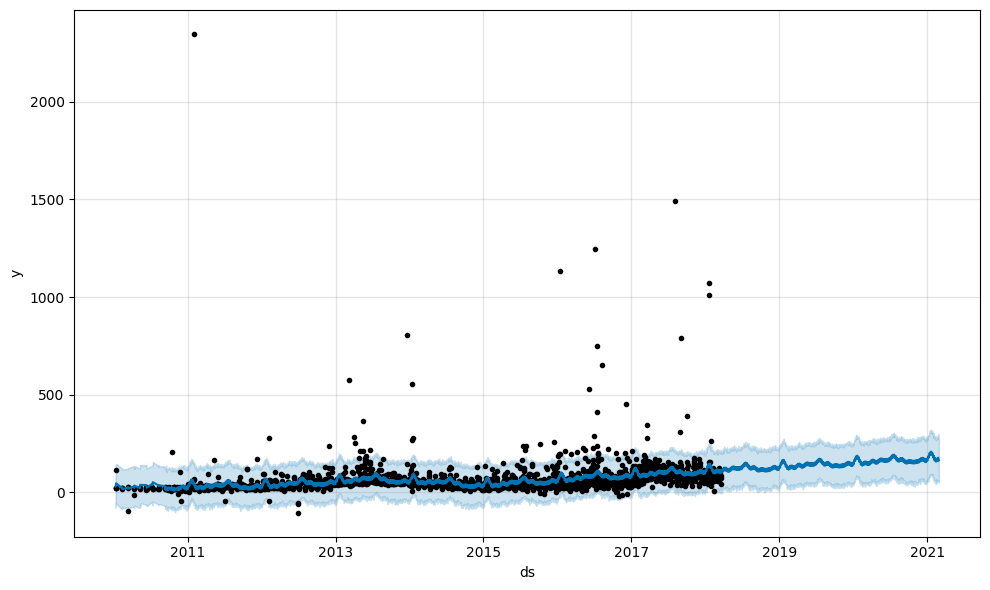

In [26]:
model.plot(forecast)
plt.show()

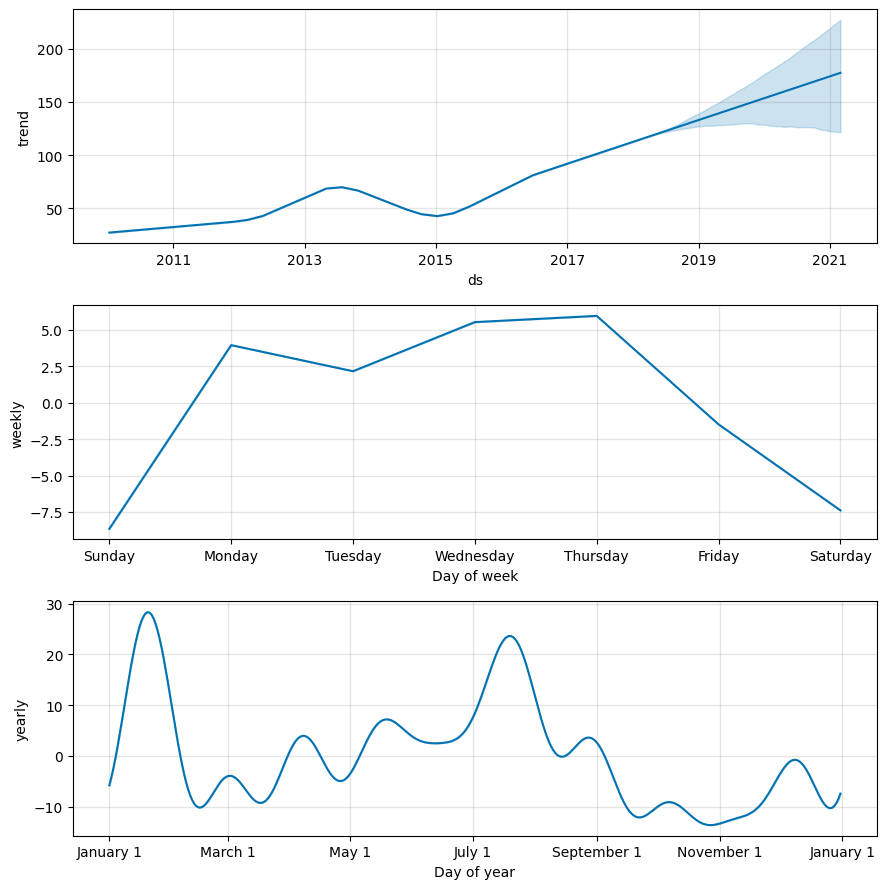

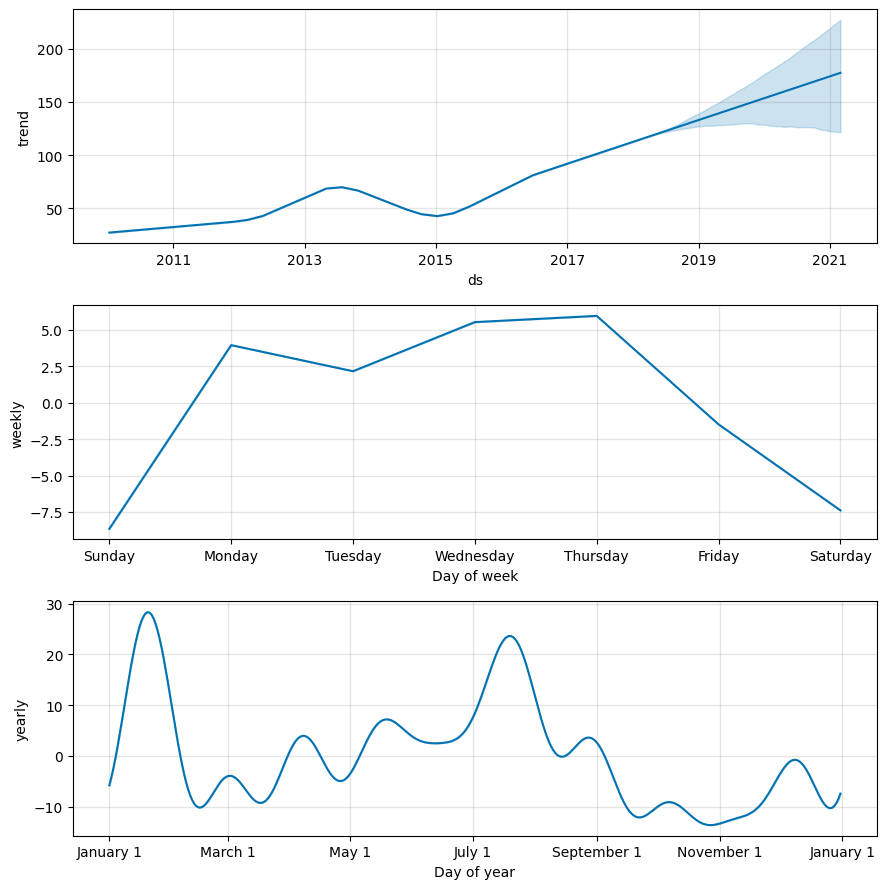

In [27]:
model.plot_components(forecast)

In [28]:
actual=forecast.iloc[2758:,18]

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt
sqrt(mean_squared_error(df_test['y'], actual)) 

144.31285364979843

In [30]:
from sklearn.metrics import mean_absolute_error as mae
error = mae(df_test['y'], actual)
print("Mean absolute error : " + str(error))

Mean absolute error : 88.12286533416308
